In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## CLEANING THE DATA
df = pd.read_csv("C:/Users/User1/mlprojekti/songs.csv", encoding='ISO-8859-1') # Read the data

timbres = [elem for elem in df.columns if "timbre" in elem or "confidence" in elem] # Create a list of all column names that contain "timbre" or "confidence"

df.drop(timbres, axis=1, inplace = True) # Drop all columns names that contain "timbre" or "confidence"
df.drop(["pitch"], axis=1, inplace = True) # Drop column "pitch"


df1 = df.groupby("songID").filter(lambda x: (1 in x["Top10"].values) and (0 in x["Top10"].values))  # Check how many songs have at least 2 observations, one with Top10 == 1 and one with Top10 == 0
# len(df1)) == 0. 0 songs have been on the top 10 chart in some year but have not been on the chart in some other year.
# This means that it is enough to simply remove duplicate songs

df = df.drop_duplicates(subset=["songID"], keep="first") # Remove duplicate songs, keep the first instance
df.drop(["artistname", "artistID", "year", "songID"], axis=1, inplace = True) # Drop more columns that will not be useful

df["songnamelength"] = df["songtitle"].str.len() # Create new column that states the number of characters in the title of the song
df.drop(["songtitle"], axis=1, inplace = True) # Remove column for the song title as it is not needed anymore

df.dropna(axis=0, inplace=True) # Remove rows with NA values

df = pd.get_dummies(df, columns=["key", "timesignature"], drop_first=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7549 entries, 0 to 7573
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loudness         7549 non-null   float64
 1   tempo            7549 non-null   float64
 2   energy           7549 non-null   float64
 3   Top10            7549 non-null   int64  
 4   songnamelength   7549 non-null   int64  
 5   key_1            7549 non-null   bool   
 6   key_2            7549 non-null   bool   
 7   key_3            7549 non-null   bool   
 8   key_4            7549 non-null   bool   
 9   key_5            7549 non-null   bool   
 10  key_6            7549 non-null   bool   
 11  key_7            7549 non-null   bool   
 12  key_8            7549 non-null   bool   
 13  key_9            7549 non-null   bool   
 14  key_10           7549 non-null   bool   
 15  key_11           7549 non-null   bool   
 16  timesignature_1  7549 non-null   bool   
 17  timesignature_3  75

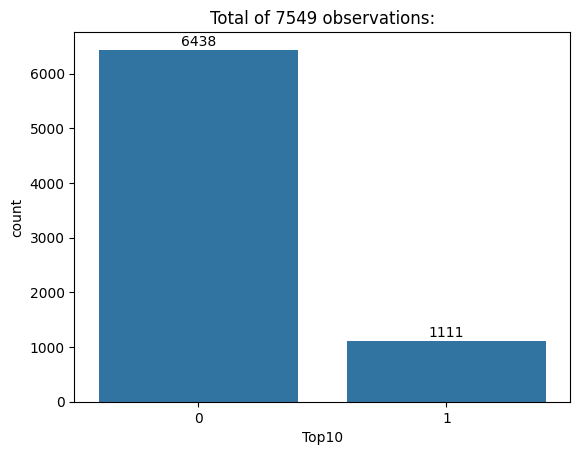

In [19]:
#PLOTTING
ax = sns.countplot(x="Top10", data=df)
plt.title(f"Total of {len(df)} observations:")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()), ha = 'center', va = 'baseline', 
                fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')
plt.show()

In [20]:
y = df["Top10"] # Label vector
X = df.drop(["Top10"], axis=1) # Feature vectors



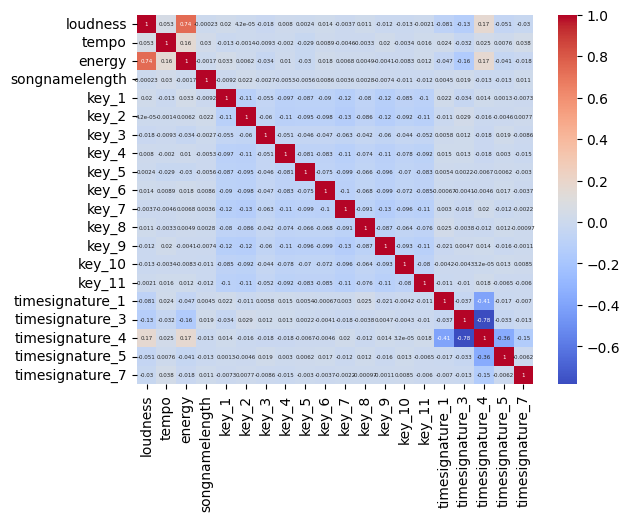

In [21]:
correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 4})
plt.show()

In [22]:
#Energy and loudness correlate too much (between 0.7-0.9). One has to be removed. Check which predicts the label with higher acuracy.

for feature in df.columns:
    if feature == "energy" or feature == "loudness":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(df[[feature]], df["Top10"], test_size=0.2, random_state=42)
        clf1 = LogisticRegression(class_weight='balanced')
        clf1.fit(X_train1, y_train1)
        y_pred1 = clf1.predict(X_test1)
        accuracy1 = accuracy_score(y_test1, y_pred1)

        print(f"Accuracy of classification based on {feature}, Accuracy: {accuracy1}")


Accuracy of classification based on loudness, Accuracy: 0.6185430463576159
Accuracy of classification based on energy, Accuracy: 0.6125827814569537


In [23]:
# energy seems to predict the label slightly worse so let's remove energy
X.drop(["energy"], axis=1, inplace=True)

Accuracy of classification: 0.5735099337748344


c:\Users\User1\mlprojekti\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Confusion Matrix')

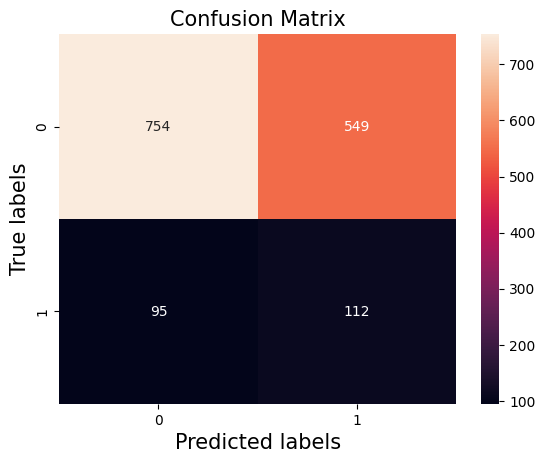

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # Split data into training and testing data

clf = LogisticRegression(class_weight='balanced')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of classification: {accuracy}")

conf_mat = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)


Accuracy of random forest classifier: 0.8582781456953642


Text(0.5, 1.0, 'Confusion Matrix')

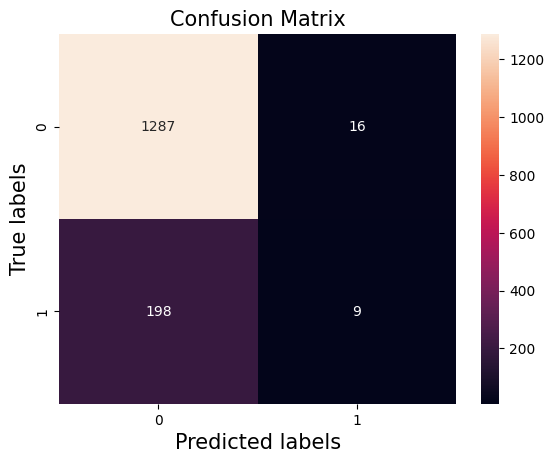

In [31]:
# RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of random forest classifier: {accuracy_rf}")

conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
ax= plt.subplot()

sns.heatmap(conf_mat_rf, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)